# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [163]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_excel('geo.xlsx')
data.drop(['Unnamed: 0'], axis = 1, inplace = True)
data

,x,y,comment_class
0,37.612416,55.777454,-1
1,37.612416,55.777454,-1
2,37.603298,55.742108,-1
3,37.558526,55.728758,-1
4,37.566431,55.731794,-1
...,...,...,...
108801,37.454528,55.792331,-1
108802,37.384325,55.899068,-1
108803,37.421066,55.848756,1
108804,37.448509,55.793065,-1


Посмотрим исходные данные

<AxesSubplot:xlabel='x', ylabel='y'>

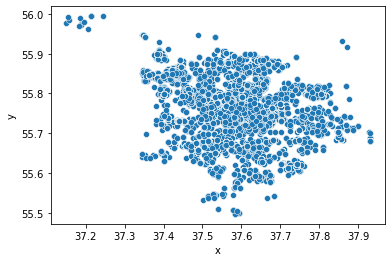

In [4]:
sns.scatterplot(data['x'], data['y'])

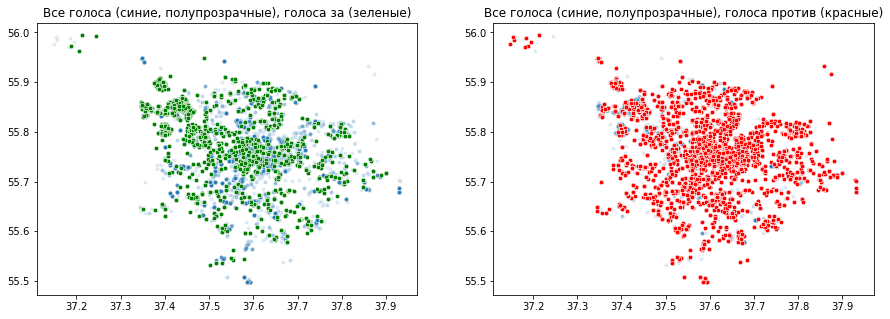

In [70]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))

ax1.scatter(data['x'], data['y'], alpha = 0.15, s = 15, edgecolor = 'white', linewidths = 0.5)
ax1.scatter(data[data['comment_class'] == 1]['x'], data[data['comment_class'] == 1]['y'], \
            color  = 'g', s = 20, edgecolor = 'white', linewidths = 0.5)
ax1.set_title('Все голоса (синие, полупрозрачные), голоса за (зеленые)')

ax2.set_title('Все голоса (синие, полупрозрачные), голоса против (красные)')
ax2.scatter(data['x'], data['y'], alpha = 0.15, s = 15, edgecolor = 'white', linewidths = 0.5)
ax2.scatter(data[data['comment_class'] == -1]['x'], data[data['comment_class'] == -1]['y'], color \
            = 'r', s = 20, edgecolor = 'white', linewidths = 0.5)

Начнем с аллогиртма KMeans

In [5]:
kmeans = KMeans(n_clusters = 3, random_state = 12)
kmeans_pred = kmeans.fit_predict(data[['x','y']])
kmeans_centers = kmeans.fit(data[['x','y']]).cluster_centers_

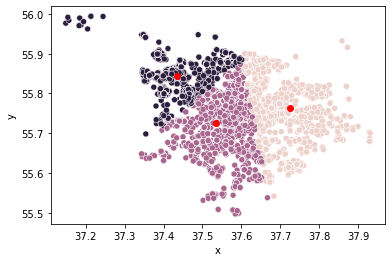

In [6]:
sns.scatterplot(data['x'], data['y'], hue = kmeans_pred, cmap = 'winter', legend = False)
plt.scatter(kmeans_centers[:,0], kmeans_centers[:,1], c = 'r')

Подберем оптимальное число кластеров

In [12]:
clusters_inertia_list = []

for k in range(1,15):
    clf_kmeans = KMeans(n_clusters = k)
    clusters_kmeans = clf_kmeans.fit_predict(data[['x','y']])
    clusters_inertia_list.append(clf_kmeans.inertia_)

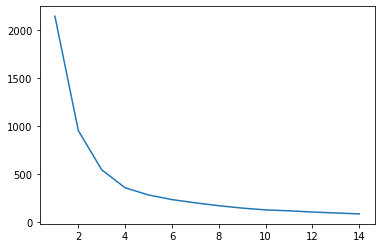

In [8]:
plt.plot(range(1,15), clusters_inertia_list)

Посмотрим на разность

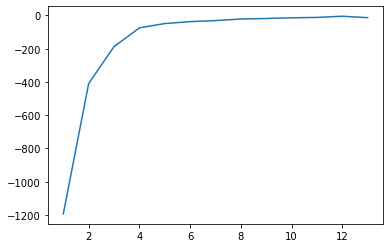

In [22]:
plt.plot(range(1,14), np.diff(clusters_inertia_list))

Найдем оптимальное число кластеров

$$k_{opt} = argmin(\frac{inertia_{k+1}-inertia_{k}}{inertia_{k}-inertia_{k-1}})$$

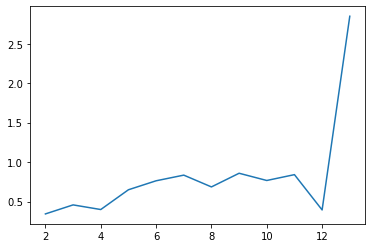

In [29]:
plt.plot(range(2,14), np.diff(clusters_inertia_list)[1:]/np.diff(clusters_inertia_list)[:-1])

#### По параметру k(оптимальный) лучшее количество кластеров 2,3,4 и 12

Посмотрим как будет работать алгоритм со всеми признаками

In [105]:
kmeans = KMeans(n_clusters = 3, random_state = 12)
kmeans_pred = kmeans.fit_predict(data)
kmeans_centers = kmeans.fit(data).cluster_centers_

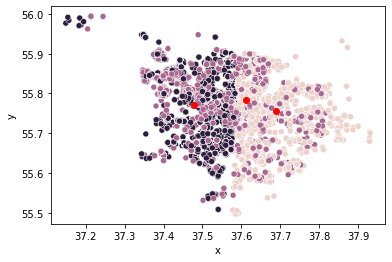

In [106]:
sns.scatterplot(data['x'], data['y'], hue = kmeans_pred, cmap = 'winter', legend = False)
plt.scatter(kmeans_centers[:,0], kmeans_centers[:,1], c = 'r')

Попробуем другие алгоритмы кластеризации данных

In [94]:
d = data.sample(20000).sort_index()

Весь объем данных не может быть использован в DBSCAN, было подобрано, что 20000 не "ломает" алгоритм

In [98]:
dbscan_cluster = DBSCAN().fit_predict(d)

<AxesSubplot:xlabel='x', ylabel='y'>

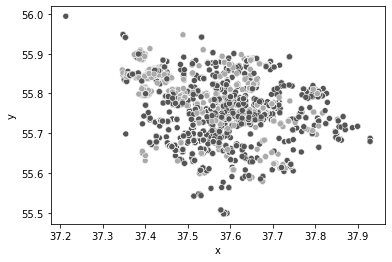

In [112]:
sns.scatterplot(d['x'], d['y'], hue = dbscan_cluster, palette = 'gray', legend = False)

In [159]:
d_agg = data.sample(30000).sort_index()

In [160]:
agg_claster = AgglomerativeClustering(n_clusters = 3).fit(d_agg[['x','y']])

<AxesSubplot:xlabel='x', ylabel='y'>

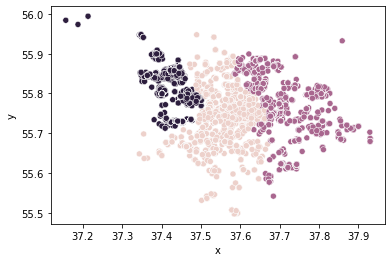

In [162]:
sns.scatterplot(d_agg['x'], d_agg['y'], hue = agg_claster.labels_, cmap = 'winter', legend = False)